In [2]:
import os 
os.chdir("/content/drive/My Drive/HUST/ki20192/image_caption")
os.getcwd()

'/content/drive/My Drive/HUST/ki20192/image_caption'

In [7]:
cd data

/content/drive/My Drive/HUST/ki20192/image_caption/data


In [8]:
!unzip Flickr8k_Dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/342964126

In [9]:
!unzip Flickr8k_text.zip

Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


In [10]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [11]:
cd ..

/content/drive/My Drive/HUST/ki20192/image_caption


In [12]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [13]:
#read file image and caption 
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "data/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [18]:
def load_descriptions(doc):
    """
    save caption key-value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
    """
    mapping = dict()
	# process lines
    for line in doc.split('\n'):
		# split line by white space
        tokens = line.split()
        #exception 
        if len(line) < 2:
            continue
		# take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
        image_id = image_id.split('.')[0]
		# convert description tokens back to string
        image_desc = ' '.join(image_desc)
		# create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
		# store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)

In [19]:
print('Loaded: ', len(descriptions))

Loaded:  8092


In [20]:
def clean_descriptions(descriptions):
	"""
    preprocess text 
    """
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [22]:
def save_descriptions(descriptions, filename):
    """
    save file
    """
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [27]:
def load_set(filename):
    """
    load data for train set, test set
    """
    
    doc = load_doc(filename)
    dataset = list()
	# process line by line
    for line in doc.split('\n'):
		# skip empty lines
        if len(line) < 1:
            continue
		# get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = './data/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset:', len(train))

Dataset: 6000


In [28]:
images = './data/Flicker8k_Dataset/'
# get image
img = glob.glob(images + '*.jpg')

In [29]:
#train set
train_images_file = './data/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [31]:
# test set
test_images_file = './data/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [33]:
# add 'startseq', 'endseq' 
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

Descriptions: train= 6000


In [34]:
# Load image, resize
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [35]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


In [36]:
# create new model
model_new = Model(model.input, model.layers[-2].output)

In [37]:
# Image embedding thành vector (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [38]:
#  encode image in traning set
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

In [39]:
#save embedding
with open("./data/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [40]:
# encode image in test set
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)

In [41]:
# Save test to disk
with open("./data/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)


In [42]:
train_features = load(open("./data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [43]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [47]:
# df > 10
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed word', len(word_counts), len(vocab))

preprocessed word 7578 1651


In [48]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [49]:
vocab_size = len(ixtoword) + 1 # add 1 padding word 
vocab_size 

1652

In [51]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length:', max_length)

Description Length: 34


In [52]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [53]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, './data/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [54]:

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 200)

In [55]:
# build model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [56]:

# Layer 2 use GLOVE Model so don't train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [63]:
opt = Adam(lr=0.0001, beta_1=0.5)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [64]:
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [66]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/1
1000/1000 [==============================] - 105s 105ms/step - loss: 5.0009
Epoch 1/1
1000/1000 [==============================] - 104s 104ms/step - loss: 4.3751
Epoch 1/1
1000/1000 [==============================] - 106s 106ms/step - loss: 4.0431
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.8515
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.7257
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.6269
Epoch 1/1
1000/1000 [==============================] - 110s 110ms/step - loss: 3.5466
Epoch 1/1
1000/1000 [==============================] - 110s 110ms/step - loss: 3.4784
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.4204
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 3.3693


In [72]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00005)
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [73]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.3323
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.2802
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.2536
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 3.2285
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 3.2075
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 3.1894
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.1718
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 3.1553
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.1396
Epoch 1/1
1000/1000 [==============================] - 107s 107ms/step - loss: 3.1247


In [79]:
model.save_weights('./data/model_weights/model_3124.h5')

In [80]:
images = './data/Flicker8k_Dataset/'

In [81]:

with open("./data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [82]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

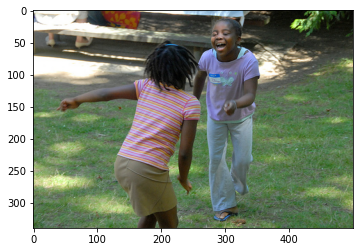

little boy in pink shirt and jeans is walking on the grass


In [86]:
z=16
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))